In [ ]:
import pandas as pd

meta_path = "/content/drive/MyDrive/MusicMNIST_Project/metadata/Annotations_Instruments_Split_Train.csv"
meta = pd.read_csv(meta_path)

# 앞부분 확인
print(meta.head())


                filename  classID class    set         ground_truth
0  A-1_German_Studio.wav        0   A-1  train  A-1_Sheet_Music.jpg
1  B-1_German_Studio.wav        2   B-1  train  B-1_Sheet_Music.jpg
2   C0_German_Studio.wav        3    C0  train   C0_Sheet_Music.jpg
3   D0_German_Studio.wav        5    D0  train   D0_Sheet_Music.jpg
4   E0_German_Studio.wav        7    E0  train   E0_Sheet_Music.jpg


In [ ]:

BASE_PATH = "/content/drive/MyDrive/MusicMNIST_Project"
TRAIN_AUDIO_DIR = f"{BASE_PATH}/train"
IMAGE_DIR = f"{BASE_PATH}/images"
CSV_PATH = f"{BASE_PATH}/metadata/Annotations_Instruments_Split_Train.csv"
TEST_DIR = f'{BASE_PATH}/test'


In [ ]:
!pip install librosa


In [ ]:
import librosa
import numpy as np

def wav_to_mel(path, sr=22050, n_mels=128, duration=3):
    y, _ = librosa.load(path, sr=sr, duration=duration)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db = mel_db[..., :130]  # (128, 130)로 고정 (3초)
    mel_db = np.expand_dims(mel_db, axis=-1)  # 채널 추가
    return mel_db


In [ ]:
import tensorflow as tf
class MultiModalDataset(tf.keras.utils.Sequence):
    def __init__(self, df, image_dir, audio_dir, batch_size=32, input_size=(299, 299), num_classes=88):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.audio_dir = audio_dir
        self.batch_size = batch_size
        self.input_size = input_size
        self.num_classes = num_classes

    def __len__(self):
        return len(self.df) // self.batch_size

    def __getitem__(self, idx):
        batch_df = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]

        image_batch = []
        audio_batch = []
        label_batch = []

        for _, row in batch_df.iterrows():
            # 이미지
            image_path = os.path.join(self.image_dir, row['ground_truth'])
            img = cv2.imread(image_path)
            img = cv2.resize(img, self.input_size)
            img = tf.keras.applications.xception.preprocess_input(img.astype('float32'))
            image_batch.append(img)

            # 오디오
            audio_path = os.path.join(self.audio_dir, row['filename'])
            mel = wav_to_mel(audio_path)
            audio_batch.append(mel)

            # 라벨
            label_batch.append(np.array(row['label_cat']))

        return [np.array(image_batch), np.array(audio_batch)], np.array(label_batch)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, GlobalAveragePooling2D,
    Conv2D, MaxPooling2D, Flatten, Concatenate
)

# 🔹 이미지 입력 (Xception 구조 유지)
xception_input = Input(shape=(299, 299, 3), name='image_input')
base_model = Xception(weights='imagenet', include_top=False, input_tensor=xception_input)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
image_feature = x  # softmax 전에 feature만 추출

# 🔸 오디오 입력 (Mel spectrogram → CNN)
audio_input = Input(shape=(128, 130, 1), name='audio_input')
a = Conv2D(32, (3, 3), activation='relu')(audio_input)
a = MaxPooling2D((2, 2))(a)
a = Conv2D(64, (3, 3), activation='relu')(a)
a = MaxPooling2D((2, 2))(a)
a = Flatten()(a)
a = Dense(128, activation='relu')(a)
audio_feature = a

# 🔗 이미지 + 오디오 feature 병합
merged = Concatenate()([image_feature, audio_feature])
merged = Dropout(0.3)(merged)
merged = Dense(128, activation='relu')(merged)

# 🎯 최종 출력: 88-class softmax
output = Dense(88, activation='softmax', name='output')(merged)

# 🧠 멀티모달 모델 구성
multi_input_model = Model(inputs=[xception_input, audio_input], outputs=output)

# 🔧 컴파일
multi_input_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 📌 모델 요약
multi_input_model.summary()


18620416/83683744 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

KeyboardInterrupt: 

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

df = pd.read_csv(CSV_PATH)
print(df.head())

# 클래스 인코딩
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['class'])  # 'note' 열은 계이름
num_classes = len(label_encoder.classes_)
df['label_cat'] = to_categorical(df['label'], num_classes=num_classes).tolist()


                filename  classID class    set         ground_truth
0  A-1_German_Studio.wav        0   A-1  train  A-1_Sheet_Music.jpg
1  B-1_German_Studio.wav        2   B-1  train  B-1_Sheet_Music.jpg
2   C0_German_Studio.wav        3    C0  train   C0_Sheet_Music.jpg
3   D0_German_Studio.wav        5    D0  train   D0_Sheet_Music.jpg
4   E0_German_Studio.wav        7    E0  train   E0_Sheet_Music.jpg


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.utils import Sequence
import random
import os
import librosa
import tensorflow as tf

# Mel-spectrogram 변환 함수
def wav_to_mel(path, sr=22050, n_mels=128, duration=3, fixed_frames=130):
    y, _ = librosa.load(path, sr=sr, duration=duration)

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)  # (128, variable)

    # 시간축 길이 맞추기 (padding or truncating)
    if mel_db.shape[1] < fixed_frames:
        pad_width = fixed_frames - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0,0), (0, pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :fixed_frames]

    mel_db = mel_db[..., np.newaxis]  # (128, 130, 1)
    return mel_db


# 멀티모달 데이터셋 클래스
class MultiModalDataset(Sequence):
    def __init__(self, df, image_dir, audio_dir, batch_size=16, input_size=(299, 299), **kwargs):
        super().__init__(**kwargs)
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.audio_dir = audio_dir
        self.batch_size = batch_size
        self.input_size = input_size
        self.indices = list(range(len(df)))

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, idx):
        batch_df = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]

        image_batch = []
        audio_batch = []
        label_batch = []

        for _, row in batch_df.iterrows():
            # 이미지 처리
            img_path = os.path.join(self.image_dir, row['ground_truth'])
            img = cv2.imread(img_path)
            img = cv2.resize(img, self.input_size)
            img = tf.keras.applications.xception.preprocess_input(img.astype('float32'))
            image_batch.append(img)

            # 오디오 처리
            audio_path = os.path.join(self.audio_dir, row['filename'])
            mel = wav_to_mel(audio_path)
            audio_batch.append(mel)

            # 라벨 처리
            label_batch.append(np.array(row['label_cat']))

        # 🧪 디버깅 출력
        print(f"[DEBUG] image_batch: {np.array(image_batch).shape}, audio_batch: {np.array(audio_batch).shape}, label_batch: {np.array(label_batch).shape}")

        return (
            {
                "image_input": np.array(image_batch),
                "audio_input": np.array(audio_batch)
            },
            np.array(label_batch, dtype=np.float32)
        )

    def on_epoch_end(self):
        random.shuffle(self.indices)


Epoch 1/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 1075s 5s/step - accuracy: 0.0223 - loss: 9.1131 - val_accuracy: 0.0911 - val_loss: 4.0563
Epoch 2/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 77s 399ms/step - accuracy: 0.2057 - loss: 3.5212 - val_accuracy: 0.0521 - val_loss: 31.6859
Epoch 3/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 83s 403ms/step - accuracy: 0.5897 - loss: 1.5670 - val_accuracy: 0.7891 - val_loss: 0.8825
Epoch 4/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 69s 356ms/step - accuracy: 0.7787 - loss: 0.7485 - val_accuracy: 0.9167 - val_loss: 0.2748
Epoch 5/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 68s 351ms/step - accuracy: 0.8653 - loss: 0.4516 - val_accuracy: 0.8906 - val_loss: 0.4646
Epoch 6/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 82s 350ms/step - accuracy: 0.9128 - loss: 0.2837 - val_accuracy: 0.9297 - val_loss: 0.2880
Epoch 7/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 82s 349ms/step - accuracy: 0.8937 - loss: 0.3839 - val_accuracy: 0.8698 - val_loss: 0.5426
Epoch 7: early stopping
Restoring model weights from the end of the best epo

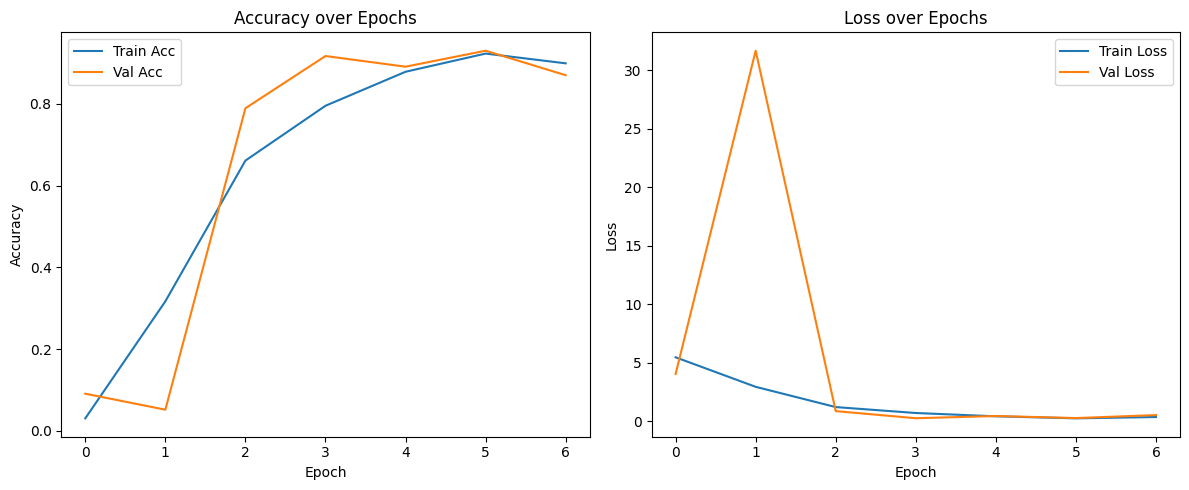

✅ 모델이 다음 경로에 저장되었습니다: /content/drive/MyDrive/MusicMNIST_Project/saved_models/multimodal_xception_audio_model.h5


In [ ]:
# ====== 1. 라이브러리 임포트 ======
import os, cv2, librosa
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Concatenate

# ====== 2. 경로 설정 ======
BASE_PATH = "/content/drive/MyDrive/MusicMNIST_Project"
IMAGE_DIR = f"{BASE_PATH}/images"
AUDIO_DIR = f"{BASE_PATH}/train"
CSV_PATH = f"{BASE_PATH}/metadata/Annotations_Instruments_Split_Train.csv"

# ====== 3. 데이터 로딩 및 라벨 인코딩 ======
df = pd.read_csv(CSV_PATH)
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['class'])
label_cat_array = to_categorical(df['label'], num_classes=88).astype(np.float32)
df['label_idx'] = df.index

# ====== 4. 오디오 → Mel 변환 함수 ======
def wav_to_mel(path, sr=22050, n_mels=128, duration=3, fixed_frames=130):
    y, _ = librosa.load(path, sr=sr, duration=duration)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    if mel_db.shape[1] < fixed_frames:
        pad_width = fixed_frames - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :fixed_frames]
    mel_db = mel_db[..., np.newaxis]
    return mel_db

# ====== 5. 멀티모달 데이터셋 클래스 ======
class MultiModalDataset(Sequence):
    def __init__(self, df, label_array, image_dir, audio_dir, batch_size=16, input_size=(299, 299), **kwargs):
        super().__init__(**kwargs)
        self.df = df.reset_index(drop=True)
        self.labels = label_array
        self.image_dir = image_dir
        self.audio_dir = audio_dir
        self.batch_size = batch_size
        self.input_size = input_size
        self.indices = list(range(len(df)))

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, idx):
        batch_df = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
        image_batch, audio_batch, label_batch = [], [], []

        for _, row in batch_df.iterrows():
            # 이미지
            img = cv2.imread(os.path.join(self.image_dir, row['ground_truth']))
            img = cv2.resize(img, self.input_size)
            img = tf.keras.applications.xception.preprocess_input(img.astype('float32'))
            image_batch.append(img)

            # 오디오
            mel = wav_to_mel(os.path.join(self.audio_dir, row['filename']))
            audio_batch.append(mel)

            # 라벨
            label_batch.append(self.labels[row['label_idx']])

        return (
            {
                "image_input": np.array(image_batch, dtype=np.float32),
                "audio_input": np.array(audio_batch, dtype=np.float32)
            },
            np.array(label_batch, dtype=np.float32)
        )

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# ====== 6. 모델 정의 (Xception + Audio CNN) ======
image_input = Input(shape=(299, 299, 3), name='image_input')
base_model = Xception(weights='imagenet', include_top=False, input_tensor=image_input)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
image_feature = x

audio_input = Input(shape=(128, 130, 1), name='audio_input')
a = Conv2D(32, (3, 3), activation='relu')(audio_input)
a = MaxPooling2D((2, 2))(a)
a = Conv2D(64, (3, 3), activation='relu')(a)
a = MaxPooling2D((2, 2))(a)
a = Flatten()(a)
a = Dense(128, activation='relu')(a)
audio_feature = a

merged = Concatenate()([image_feature, audio_feature])
merged = Dropout(0.3)(merged)
merged = Dense(128, activation='relu')(merged)
output = Dense(88, activation='softmax', name='output')(merged)

multi_input_model = Model(inputs=[image_input, audio_input], outputs=output)
multi_input_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ====== 7. 데이터셋 나누고 생성 ======
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_dataset = MultiModalDataset(train_df, label_cat_array, IMAGE_DIR, AUDIO_DIR, batch_size=8)
val_dataset = MultiModalDataset(val_df, label_cat_array, IMAGE_DIR, AUDIO_DIR, batch_size=8)

from tensorflow.keras.callbacks import EarlyStopping

# ====== 8-1. 조기 종료 콜백 설정 ======
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# ====== 8-2. 학습 시작 ======
history = multi_input_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stop],   # ✅ 콜백 반영
    verbose=1
)

# ====== 9. 시각화 ======
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ====== 10. 모델 저장 ======
MODEL_SAVE_PATH = f"{BASE_PATH}/saved_models/multimodal_xception_audio_model.h5"

# 디렉토리 없으면 생성
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

# 모델 저장
multi_input_model.save(MODEL_SAVE_PATH)
print(f"✅ 모델이 다음 경로에 저장되었습니다: {MODEL_SAVE_PATH}")


In [ ]:
import os
import cv2
import numpy as np
import librosa
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

# 경로 설정
BASE_PATH = "/content/drive/MyDrive/MusicMNIST_Project"
TEST_AUDIO_DIR = f"{BASE_PATH}/test"
IMAGE_DIR = f"{BASE_PATH}/images"
CSV_PATH = f"{BASE_PATH}/metadata/Annotations_Instruments_Split_Test.csv"
MODEL_PATH = f"{BASE_PATH}/saved_models/multimodal_xception_audio_model.h5"

# CSV 불러오기
df = pd.read_csv(CSV_PATH)

# 클래스 라벨 인코딩
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['class'])
df['label_cat'] = to_categorical(df['label'], num_classes=len(label_encoder.classes_)).tolist()

# 오디오 → Mel Spectrogram 변환
def wav_to_mel(path, sr=22050, n_mels=128, duration=3, fixed_frames=130):
    y, _ = librosa.load(path, sr=sr, duration=duration)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    if mel_db.shape[1] < fixed_frames:
        pad_width = fixed_frames - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :fixed_frames]

    mel_db = mel_db[..., np.newaxis]
    return mel_db

# 이미지 + 오디오 + 라벨 데이터 로딩
X_img, X_mel, y_true = [], [], []

for _, row in df.iterrows():
    try:
        # 이미지
        img_path = os.path.join(IMAGE_DIR, row['ground_truth'])
        img = cv2.imread(img_path)
        img = cv2.resize(img, (299, 299))
        img = tf.keras.applications.xception.preprocess_input(img.astype('float32'))
        X_img.append(img)

        # 오디오
        audio_path = os.path.join(TEST_AUDIO_DIR, row['filename'])
        mel = wav_to_mel(audio_path)
        X_mel.append(mel)

        # 라벨
        y_true.append(row['label'])

    except Exception as e:
        print(f"⚠️ 오류 발생: {row['filename']} - {e}")
        continue

X_img = np.array(X_img)
X_mel = np.array(X_mel)
y_true = np.array(y_true)

# 모델 로드 및 예측
model = load_model(MODEL_PATH)
preds = model.predict({'image_input': X_img, 'audio_input': X_mel})
y_pred = np.argmax(preds, axis=1)

# 정확도 평가
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ 테스트 정확도: {acc * 100:.2f}%")

# # 예시 출력 (10개)
# print("\n🎵 예측 vs 실제 (샘플 10개):")
# for i in range(10):
#     pred_label = label_encoder.inverse_transform([y_pred[i]])[0]
#     true_label = label_encoder.inverse_transform([y_true[i]])[0]
#     print(f"{i+1:2d}. 예측: {pred_label:5s} | 정답: {true_label:5s}")

# 예측 결과 전체 출력
print("\n🎵 예측 vs 실제 (전체 샘플):")
for i in range(len(y_pred)):
    pred_label = label_encoder.inverse_transform([y_pred[i]])[0]
    true_label = label_encoder.inverse_transform([y_true[i]])[0]
    print(f"{i+1:3d}. 예측: {pred_label:5s} | 정답: {true_label:5s}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 629ms/step

✅ 테스트 정확도: 89.73%

🎵 예측 vs 실제 (전체 샘플):
  1. 예측: A6    | 정답: A#-1 
  2. 예측: C#0   | 정답: C#0  
  3. 예측: D#0   | 정답: D#0  
  4. 예측: G#0   | 정답: G#0  
  5. 예측: C#1   | 정답: C#1  
  6. 예측: E1    | 정답: E1   
  7. 예측: F#1   | 정답: F#1  
  8. 예측: B1    | 정답: B1   
  9. 예측: E2    | 정답: E2   
 10. 예측: A2    | 정답: A2   
 11. 예측: D3    | 정답: D3   
 12. 예측: G3    | 정답: G3   
 13. 예측: C4    | 정답: C4   
 14. 예측: F4    | 정답: F4   
 15. 예측: A#4   | 정답: A#4  
 16. 예측: D#5   | 정답: D#5  
 17. 예측: G#5   | 정답: G#5  
 18. 예측: C#6   | 정답: C#6  
 19. 예측: F#6   | 정답: F#6  
 20. 예측: B6    | 정답: B6   
 21. 예측: A-1   | 정답: A#-1 
 22. 예측: C#0   | 정답: C#0  
 23. 예측: B-1   | 정답: F#0  
 24. 예측: B0    | 정답: B0   
 25. 예측: E1    | 정답: E1   
 26. 예측: A1    | 정답: A1   
 27. 예측: D2    | 정답: D2   
 28. 예측: G2    | 정답: G2   
 29. 예측: C3    | 정답: C3   
 30. 예측: F3    | 정답: F3   
 31. 예측: A#3   | 정답: A#3  
 32. 예측: D#4   | 정답: D#4  
 33. 예측: C#5   | 정답: C#5  
 34. 예측: F#5   | 정답: F#5  


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive')

from ScoreDetection import remove_noise, remove_staves, normalization, object_analysis, object_detection, recognition

import cv2
from google.colab.patches import cv2_imshow


# 이미지 경로
image_path = "/content/drive/MyDrive/상어가족.png"


# OpenCV로 이미지 읽기
image = cv2.imread(image_path)


image_1 = remove_noise(image)
image_2, staves = remove_staves(image_1)
image_3, staves = normalization(image_2, staves, 10)
image_4, objects = object_detection(image_3, staves)
image_5, objects = object_analysis(image_4, objects)
image_6, key, beats, pitches = recognition(image_5, staves, objects)


cv2_imshow(image_6)
k = cv2.waitKey(0)
if k == 27:
    cv2.destroyAllWindows()


ZeroDivisionError: float division by zero

3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step

🎶 예측된 음표 리스트 (72개):
  1: A0
  2: A5
  3: A0
  4: A0
  5: A#0
  6: A0
  7: A#0
  8: A0
  9: A#0
 10: A0
 11: A0
 12: A5
 13: E2
 14: A#0
 15: G2
 16: G2
 17: A0
 18: A3
 19: A0
 20: A0
 21: A0
 22: G2
 23: A0
 24: A0
 25: A0
 26: A0
 27: A0
 28: A0
 29: A4
 30: A#0
 31: A0
 32: A0
 33: A0
 34: A0
 35: A5
 36: A0
 37: A0
 38: A0
 39: A0
 40: A0
 41: A0
 42: A0
 43: G2
 44: A0
 45: A0
 46: A0
 47: A0
 48: C5
 49: A#0
 50: A1
 51: B0
 52: A0
 53: B0
 54: A0
 55: A3
 56: A0
 57: A5
 58: A#0
 59: A0
 60: B0
 61: A0
 62: A0
 63: A0
 64: B0
 65: A0
 66: A0
 67: B0
 68: A0
 69: A0
 70: A0
 71: D0
 72: F#4


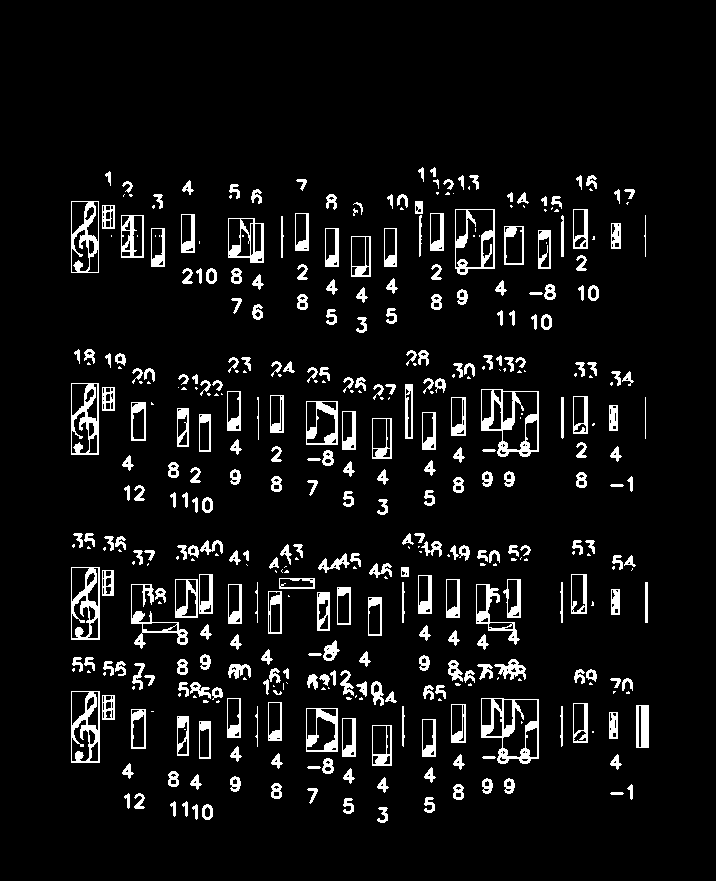

In [ ]:
import os
import cv2
import numpy as np
import librosa
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from google.colab.patches import cv2_imshow

from ScoreDetection import remove_noise, remove_staves, normalization, object_analysis, object_detection, recognition

# ====== 설정 ======
BASE_PATH = '/content/drive/MyDrive/MusicMNIST_Project'
sheet_path = '/content/drive/MyDrive/애국가_악보.jpg'
audio_path = '/content/drive/MyDrive/애국가1절.wav'
model_path = f'{BASE_PATH}/saved_models/multimodal_xception_audio_model.h5'
CSV_PATH = f"{BASE_PATH}/metadata/Annotations_Instruments_Split_Test.csv"

# ====== 슬라이딩 없이 객체 기반 음표 crop ======
def prepare_model_inputs(image, objects, input_size=(299, 299)):
    note_images = []
    bboxes = []

    for i, obj in enumerate(objects):
        stats = obj[1]
        (x, y, w, h, _) = stats
        cropped = image[y:y+h, x:x+w]
        try:
            resized = cv2.resize(cropped, input_size)
            if len(resized.shape) == 2:
                resized = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)
            else:
                resized = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
            normalized = tf.keras.applications.xception.preprocess_input(resized.astype(np.float32))
            note_images.append(normalized)
            bboxes.append((x, y, w, h))
        except:
            continue

    return np.array(note_images, dtype=np.float32), bboxes

# ====== 오디오 분할 ======
def extract_audio_segments(audio_path, num_segments):
    y, sr = librosa.load(audio_path, sr=22050)
    segment_len = int(len(y) / num_segments)

    segments = []
    for i in range(num_segments):
        start = i * segment_len
        end = start + segment_len
        y_segment = y[start:end]

        mel = librosa.feature.melspectrogram(y=y_segment, sr=sr, n_mels=128)
        mel_db = librosa.power_to_db(mel, ref=np.max)

        if mel_db.shape[1] < 130:
            pad = 130 - mel_db.shape[1]
            mel_db = np.pad(mel_db, ((0, 0), (0, pad)), mode='constant')
        else:
            mel_db = mel_db[:, :130]

        mel_db = mel_db[..., np.newaxis]  # (128, 130, 1)
        segments.append(mel_db)

    return np.array(segments, dtype=np.float32)

# ====== 전처리 및 인식 ======
image = cv2.imread(sheet_path)
image_1 = remove_noise(image)
image_2, staves = remove_staves(image_1)
image_3, staves = normalization(image_2, staves, 10)
image_4, objects = object_detection(image_3, staves)
image_5, objects = object_analysis(image_4, objects)
image_6, key, beats, pitches = recognition(image_5, staves, objects)

# ====== 모델 및 레이블 로딩 ======
model = load_model(model_path)

# CSV 불러오기
df = pd.read_csv(CSV_PATH)

# 클래스 라벨 인코딩
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['class'])
df['label_cat'] = to_categorical(df['label'], num_classes=len(label_encoder.classes_)).tolist()

# ====== 모델 입력 준비 ======
X_img, bboxes = prepare_model_inputs(image_3, objects)
X_mel = extract_audio_segments(audio_path, num_segments=len(X_img))

# ====== 예측 ======
preds = model.predict({'image_input': X_img, 'audio_input': X_mel}, verbose=1)
classes = np.argmax(preds, axis=1)
note_names = label_encoder.inverse_transform(classes)

# ====== 예측 결과 시각화 ======
for (x, y, w, h), name in zip(bboxes, note_names):
    cv2.rectangle(image_3, (x, y), (x+w, y+h), (255, 0, 0), 1)
    cv2.putText(image_3, str(name), (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

# ====== 출력 ======
print(f"\n🎶 예측된 음표 리스트 ({len(note_names)}개):")
for idx, name in enumerate(note_names, 1):
    print(f"{idx:3d}: {name}")

cv2_imshow(image_3)


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step

🎯 모델 예측 결과 (56개):
  1: B0
  2: A#0
  3: A0
  4: B0
  5: A0
  6: A#0
  7: A#0
  8: A#0
  9: G2
 10: A#0
 11: A#0
 12: B0
 13: G2
 14: A0
 15: A#0
 16: A0
 17: A#0
 18: A0
 19: A0
 20: A0
 21: B0
 22: A0
 23: A0
 24: B0
 25: A0
 26: A0
 27: A0
 28: A0
 29: A0
 30: A0
 31: A0
 32: A0
 33: A0
 34: G2
 35: A0
 36: A0
 37: B0
 38: B0
 39: A1
 40: B0
 41: A0
 42: A0
 43: A0
 44: B0
 45: A#0
 46: B0
 47: B0
 48: A0
 49: A#0
 50: B0
 51: A#0
 52: A#0
 53: A0
 54: A0
 55: A0
 56: D0


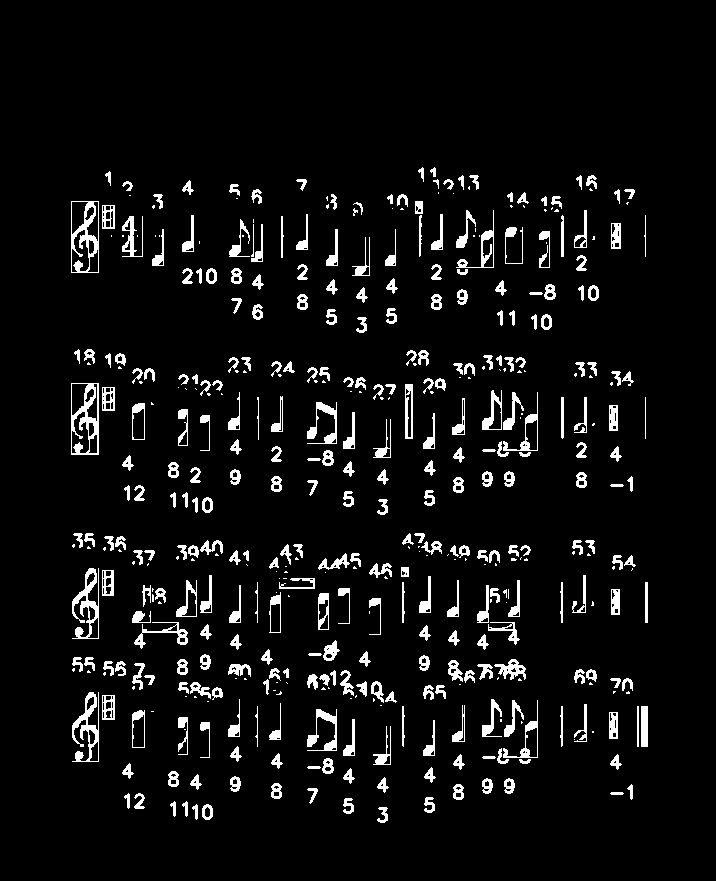

In [ ]:
def extract_note_objects(objects):
    """
    객체 중에서 진짜 '음표' 조건을 만족하는 것만 추출.
    모델 예측 대상과 정확히 1:1 매칭하기 위해 필요.
    """
    note_objs = []
    for obj in objects:
        stats = obj[1]
        stems = obj[2]
        direction = obj[3]
        (x, y, w, h, area) = stats
        # 음표 조건과 비슷한 기준 (너가 ScoreDetection.py에서 쓴 조건과 일치시킴)
        if (
            len(stems) and
            w >= 10 and
            h >= 35 and
            area >= 95
        ):
            note_objs.append(obj)
    return note_objs

# 1. 객체 중 음표만 골라냄
note_objects = extract_note_objects(objects)

# 2. 이미지 crop + 모델 입력
X_img, bboxes = prepare_model_inputs(image_3, note_objects)
X_mel = extract_audio_segments(audio_path, num_segments=len(X_img))

# 3. 모델 예측
preds = model.predict({'image_input': X_img, 'audio_input': X_mel}, verbose=1)
classes = np.argmax(preds, axis=1)
note_names = label_encoder.inverse_transform(classes)

# 4. image_6에 예측된 결과를 1:1 매핑해서 표시
for obj, name in zip(note_objects, note_names):
    stats = obj[1]
    (x, y, w, h, _) = stats
    cv2.rectangle(image_6, (x, y), (x+w, y+h), (0, 255, 0), 1)
    cv2.putText(image_6, str(name), (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# 5. 결과 출력
print(f"\n🎯 모델 예측 결과 ({len(note_names)}개):")
for idx, name in enumerate(note_names, 1):
    print(f"{idx:3d}: {name}")

cv2_imshow(image_6)


In [ ]:
def get_note_sequence_from_prediction(predictions):
    """
    모델의 softmax 출력 결과를 받아 가장 높은 확률의 인덱스를
    MIDI note number로 변환해주는 함수
    """
    note_sequence = []
    for pred in predictions:
        class_idx = np.argmax(pred)           # 확률이 가장 높은 클래스 선택
        midi_note = 21 + class_idx            # 21 ~ 108 사이로 매핑
        note_sequence.append(midi_note)
    return note_sequence


In [ ]:
note_sequences = []
for x_batch, _ in train_dataset:  # 이미지 + 오디오 배치
    preds = multi_input_model.predict(x_batch)  # shape: (batch_size, 88)
    note_seq = get_note_sequence_from_prediction(preds)
    note_sequences.extend(note_seq)
    break  # 예시니까 한 배치만 실행


In [ ]:
class MusicTransformer(tf.keras.Model):
    def __init__(self, vocab_size=88, maxlen=100, embed_dim=128, num_heads=4, ff_dim=256, num_layers=2):
        super(MusicTransformer, self).__init__()
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_embedding = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

        self.transformer_blocks = [
            TransformerBlock(embed_dim, num_heads, ff_dim)
            for _ in range(num_layers)
        ]

        self.flatten = tf.keras.layers.Flatten()
        self.dropout = tf.keras.layers.Dropout(0.1)
        self.out = tf.keras.layers.Dense(vocab_size, activation="softmax")

    def call(self, inputs):
        positions = tf.range(start=0, limit=tf.shape(inputs)[-1], delta=1)
        x = self.embedding(inputs) + self.pos_embedding(positions)
        for block in self.transformer_blocks:
            x = block(x)
        x = self.dropout(x)
        return self.out(x)


In [ ]:
def get_note_sequence_from_prediction(pred_vector, threshold=0.1):
    """ 88차원 softmax 결과를 계이름 인덱스 시퀀스로 변환 """
    note_indices = np.where(pred_vector > threshold)[0]
    return note_indices if len(note_indices) > 0 else [np.argmax(pred_vector)]


In [ ]:
# 예시: 멀티모달 모델 예측값
from tensorflow.keras.preprocessing.sequence import pad_sequences

note_sequences = []

for x, y in train_dataset:  # 이미지, 오디오 기반 멀티모달 모델
    preds = multi_input_model.predict(x)
    for pred in preds:
        note_seq = get_note_sequence_from_prediction(pred)
        note_sequences.append(note_seq)

# Transformer 입력용 시퀀스 정리
X_train = pad_sequences(note_sequences, maxlen=100, padding='pre')
y_train = pad_sequences(note_sequences, maxlen=100, padding='post')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


ValueError: math domain error

In [ ]:
transformer_model = MusicTransformer()
transformer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

transformer_model.fit(X_train, y_train, epochs=20, batch_size=16)


In [ ]:
import pretty_midi

def generate_music_from_transformer(start_seq, model, length=32):
    output = start_seq.copy()
    for _ in range(length):
        inp = pad_sequences([output], maxlen=100, padding='pre')
        pred = model.predict(inp)[0][-1]
        next_note = np.argmax(pred)
        output.append(next_note)
    return output

def save_midi(note_seq, filename="output.mid"):
    midi = pretty_midi.PrettyMIDI()
    piano = pretty_midi.Instrument(program=0)
    start = 0
    for note in note_seq:
        pitch = note + 21  # MIDI pitch range 보정
        note = pretty_midi.Note(velocity=100, pitch=pitch, start=start, end=start + 0.5)
        piano.notes.append(note)
        start += 0.5
    midi.instruments.append(piano)
    midi.write(filename)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


InvalidArgumentError: Exception encountered when calling MusicTransformer.call().

[1m{{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} required broadcastable shapes [Op:AddV2] name: [0m

Arguments received by MusicTransformer.call():
  • x=tf.Tensor(shape=(1, 500), dtype=int32)

In [ ]:
generated_seq = generate_music_from_transformer(start_seq=[60, 62, 64], model=transformer_model)
save_midi(generated_seq, filename="generated_music.mid")


In [ ]:
sequence_to_midi(generated_sequence, filename="generated_from_musicmnist.mid")


In [ ]:
import pretty_midi
import numpy as np

def prediction_to_midi(pred_seq, filename="output.mid", velocity=100, duration=0.5):
    """
    예측된 음표 시퀀스를 MIDI 파일로 저장
    :param pred_seq: (seq_len,) 정수 인덱스 시퀀스 (0~127 범위)
    :param filename: 저장할 MIDI 파일명
    :param velocity: 음표 세기 (0~127)
    :param duration: 각 음표 길이 (초 단위)
    """
    midi = pretty_midi.PrettyMIDI()
    piano = pretty_midi.Instrument(program=0)  # Acoustic Grand Piano

    current_time = 0.0
    for pitch in pred_seq:
        if pitch < 0 or pitch > 127: continue  # MIDI pitch 범위 제한
        note = pretty_midi.Note(velocity=velocity, pitch=int(pitch),
                                start=current_time, end=current_time + duration)
        piano.notes.append(note)
        current_time += duration

    midi.instruments.append(piano)
    midi.write(filename)
    print(f"✅ MIDI saved to: {filename}")


In [ ]:
import subprocess

def convert_midi_to_mp3(midi_path='output.mid', sf2_path='FluidR3_GM.sf2'):
    wav_path = midi_path.replace('.mid', '.wav')
    mp3_path = midi_path.replace('.mid', '.mp3')

    subprocess.run(['fluidsynth', '-ni', sf2_path, midi_path, '-F', wav_path, '-r', '44100'], check=True)
    subprocess.run(['ffmpeg', '-y', '-i', wav_path, mp3_path], check=True)
    print(f"✅ MP3 saved to: {mp3_path}")

In [ ]:
import pandas as pd

meta_df = pd.read_csv(CSV_PATH)
print(meta_df.head())  # 확인용


                filename  classID class    set         ground_truth
0  A-1_German_Studio.wav        0   A-1  train  A-1_Sheet_Music.jpg
1  B-1_German_Studio.wav        2   B-1  train  B-1_Sheet_Music.jpg
2   C0_German_Studio.wav        3    C0  train   C0_Sheet_Music.jpg
3   D0_German_Studio.wav        5    D0  train   D0_Sheet_Music.jpg
4   E0_German_Studio.wav        7    E0  train   E0_Sheet_Music.jpg


In [ ]:
import numpy as np
from PIL import Image
import tensorflow as tf
import os

NUM_CLASSES = 88
SEQ_LEN = 1  # 단일 음표

def load_img_label(image_filename, label):
    img_path = os.path.join(IMAGE_DIR, image_filename)
    image = Image.open(img_path).convert("RGB").resize((299, 299))
    image = np.array(image).astype("float32") / 255.0

    # label one-hot encoding
    label_onehot = tf.keras.utils.to_categorical(label, num_classes=NUM_CLASSES)
    return image, label_onehot


In [ ]:
def make_music_dataset(meta_df, batch_size=32):
    images = []
    decoder_inputs = []
    labels = []

    for _, row in meta_df.iterrows():
        img, label = load_img_label(row["ground_truth"], row["classID"])
        images.append(img)
        labels.append(label)

        # decoder input: zero 초기화 (shape: SEQ_LEN x emb_dim)
        dec_input = np.zeros((SEQ_LEN, 512))  # emb_dim=512로 맞춤
        decoder_inputs.append(dec_input)

    # 배열 변환
    images = np.array(images)
    decoder_inputs = np.array(decoder_inputs)
    labels = np.array(labels)
    labels = np.reshape(labels, (labels.shape[0], SEQ_LEN, NUM_CLASSES))  # (batch, seq_len, class)

    # ✅ 두 개의 입력을 tuple로 전달
    return tf.data.Dataset.from_tensor_slices(((images, decoder_inputs), labels)).shuffle(500).batch(batch_size)


해당 아래 절대로 지우지마 우진아 제발 부탁이다

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

# ====== Xception 모델 로드 ======
MODEL_PATH = '/content/drive/MyDrive/MusicMNIST_Project/saved_models/multimodal_xception_audio_model.h5'
xception_model = tf.keras.models.load_model(MODEL_PATH)

# ====== 악보 이미지 전처리 함수 ======
def preprocess_sheet(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
    return thresh

# ====== 줄 별 음표 자르기 함수 ======
def extract_note_patches(thresh_img, original_img, patch_size=(299, 299), min_area=30):
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    note_regions = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w * h > min_area:  # 너무 작은 점 등은 제외
            note = original_img[y:y+h, x:x+w]
            note = cv2.resize(note, patch_size)
            note = tf.keras.applications.xception.preprocess_input(note.astype('float32'))
            note_regions.append(((x, y), note))

    # 줄별 정렬: 위→아래 줄 순서, 각 줄은 좌→우
    def line_sort_key(pos):
        return (pos[0][1] // 50, pos[0][0])  # y좌표 → 줄, x좌표 → 순서

    note_regions.sort(key=line_sort_key)
    return [patch for _, patch in note_regions]

# ====== 예측 함수 ======
def predict_midi_sequence(note_images):
    input_batch = np.stack(note_images, axis=0)
    preds = xception_model.predict(input_batch)
    midi_sequence = np.argmax(preds, axis=1)
    return midi_sequence.tolist()

# ====== 실행 파이프라인 함수 ======
def sheet_to_midi_sequence(image_path):
    print(f"🎼 Processing: {image_path}")
    original_img = cv2.imread(image_path)
    thresh_img = preprocess_sheet(image_path)
    note_patches = extract_note_patches(thresh_img, original_img)

    if not note_patches:
        print("⚠️ 음표를 찾을 수 없습니다.")
        return []

    midi_sequence = predict_midi_sequence(note_patches)
    print(f"🎵 MIDI 시퀀스 예측 결과: {midi_sequence}")
    return midi_sequence
